In [12]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'

my_cmap = plt.get_cmap('gray')
#Standard cycle for collors and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)

#Project Specific packages:
import zipfile
#import DWFT as fp
import os as os
# import pywt as py
import pandas as pd


def PlotFingerPrint(FpScat, xName, title='', FP='mexh'):
    
    #FpScat = fp.getLabeledThumbprint(data, FP)
    FpScat = np.matrix(FpScat)
    
    Al,Ms  = np.meshgrid(xName,np.linspace(1,50,50))

    fig1 = plt.figure(figsize=(6.67,3.75))
    ax1 = plt.axes()
    cs1 = ax1.contourf(Al,Ms, FpScat,cmap=my_cmap,levels=10)

    if Titles: plt.title(title)
    if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "").replace(".txt","")+FFormat)

    plt.show()

Directory = "E:\\Documents\\Dan\\PhD\\Play\\ASC\\"
files = os.listdir(Directory)
Dots = 1000
Start = 2615

for Filename in files:
    print(Filename[-3:])
    if Filename[-3:] == 'csv':
        Results = []
        DataSet = np.genfromtxt(open(Directory+'/'+Filename,'r'), delimiter=',',skip_header=4)
        #plt.plot(DataSet[:,0],DataSet[:,1], label = 'X')
        #plt.plot(DataSet[:,0],DataSet[:,2], label = 'Y')
        for j in range(Dots):
            i = j + Start
            Results.append([DataSet[i,1],np.sqrt(DataSet[i,2]**2+DataSet[i,3]**2+DataSet[i,4]**2)])
        Results = np.matrix(Results)
        plt.plot(Results[:,0],Results[:,1], label = 'R')

        title = Filename + 'R-'
        if Ledgends: plt.legend()
        if Titles: plt.title(title)
        if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
        plt.show()
        PlotFingerPrint(np.ravel(Results[:,1]),Results[:,0],title)

#DataSet = np.genfromtxt(open("E:\\Documents\\Dan\\PhD\\Play\\ASC\\60kPoints-210709-1026.csv",'r'), delimiter=',',skip_header=4)
#DataSet = np.genfromtxt(open("C:\\Users\\dhendrickson\\Pone Drive\\OneDrive - The Port of Virginia\\Shared with Everyone\\60kAccel-210713-1700.csv",'r'), delimiter=',',skip_header=4)
#folder = "C:\\Users\\hendrickson\\Desktop\\temp\\"
#folder = "g:\\"
folder = "g:\\Excel Versions\\"


Results = []
for i in range(np.shape(DataSet)[0]):
    c = DataSet[i,1]
    x = DataSet[i,2]
    y = DataSet[i,3]
    z = DataSet[i,4]
    r = np.sqrt(x**2 + y**2 + z**2)
    t = np.arccos(z / r)
    p = np.arctan(y / x)
    Results.append([c,x,y,z,r,t,p])
Results = np.matrix(Results)

Names = ['Time',
         'x',
         'y',
         'z',
         'r',
         'theta',
         'phi']

StdDev = [  np.std(Results[:,1]),
            np.std(Results[:,2]),
            np.std(Results[:,3]),
            np.std(Results[:,4]),
            np.std(Results[:,5]),
            np.std(Results[:,6])]

Results = []
for i in range(np.shape(DataSet)[0]):
    c = DataSet[i,1]
    x = DataSet[i,2]
    y = DataSet[i,3]
    z = DataSet[i,4]
    r = np.sqrt(x**2 + y**2 + z**2)
    t = np.arccos(z / r)
    p = np.arctan(y / x)
    Results.append([c,x,y,z,r,t,p])
Results = np.matrix(Results)

Names = ['Time',
         'x',
         'y',
         'z',
         'r',
         'theta',
         'phi']

StdDev = [  np.std(Results[:,1]),
            np.std(Results[:,2]),
            np.std(Results[:,3]),
            np.std(Results[:,4]),
            np.std(Results[:,5]),
            np.std(Results[:,6])]

BlockSize = 500

for i in range(int(np.shape(DataSet)[0]/BlockSize)):
    Start = i * BlockSize
    End = Start + BlockSize

    LocalStdDev = [ np.std(Results[Start:End,1]),
                    np.std(Results[Start:End,2]),
                    np.std(Results[Start:End,3]),
                    np.std(Results[Start:End,4]),
                    np.std(Results[Start:End,5]),
                    np.std(Results[Start:End,6])]
    
    for k in range(6):
        
        if np.abs((LocalStdDev[k])/StdDev[k]) > 2:
            plt.plot(Results[Start:End,0],Results[Start:End,k], label = Names[k])

            title = Names[k] + ' starting at step ' + str(i * BlockSize)
            if Ledgends: plt.legend()
            if Titles: plt.title(title)
            if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
            plt.show()
            PlotFingerPrint(np.ravel(Results[Start:End,k]),Results[Start:End,0],title)


import random
import multiprocessing
from joblib import Parallel, delayed
import tictoc as tt

import pywt
from pywt._extensions._pywt import (DiscreteContinuousWavelet, ContinuousWavelet,
                                Wavelet, _check_dtype)
from pywt._functions import integrate_wavelet, scale2frequency
from time import time as ti

def getThumbprint(data, wvt, ns=50, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=True):
    '''
    STarted with Spenser Kirn's code, modifed by DCH
    Updated version of the DWFT function above that allows plotting of just
    valleys or just peaks or both. To plot just valleys set valleysorpeaks='valleys'
    to plot just peaks set valleysorpeaks='peaks' or 'both' to plot both.
    '''
    # First take the wavelet transform and then normalize to one
    cfX, freqs = cwt_fixed(data, np.arange(1,ns+1), wvt)
    cfX = np.true_divide(cfX, abs(cfX).max()*normconstant)
    
    fp = np.zeros((len(data), ns), dtype=int)
    
    # Create the list of locations between -1 and 1 to preform slices. Valley
    # slices will all be below 0 and peak slices will all be above 0.
    if valleysorpeaks == 'both':
        slicelocations1 = np.arange(-1 ,0.0/numslices, 1.0/numslices)
        slicelocations2 = np.arange(1.0/numslices, 1+1.0/numslices, 1.0/numslices)
        slicelocations = np.array(np.append(slicelocations1,slicelocations2))
        
    for loc in slicelocations:
        for y in range(0, ns):
            for x in range(0, len(data)):
                if cfX[y, x]>=(loc-(slicethickness/2)) and cfX[y,x]<= (loc+(slicethickness/2)):
                    fp[x,y] = 1
                    
    fp = np.transpose(fp[:,:ns])

def getAcceleration(FileName):
    try:
        DataSet = np.genfromtxt(open(folder+FileName,'r'), delimiter=',',skip_header=4)
        return [[FileName,'x',DataSet[:,2]],[FileName,'y',DataSet[:,3]],[FileName,'z',DataSet[:,4]]]
    except:
        return [False,FileName,False]

def makePrints(DataArray):
    FingerPrint = fp.getLabeledThumbprint(DataArray[2],'gaus2')
    return [DataArray[0],DataArray[1],FingerPrint]

def getResults(FPnMd):
    Results = []
    Ridges = fp.RidgeCount(FPnMd[2][:,500:59500])
    return [FPnMd[0],FPnMd[1],Ridges]

def CountAboveThreshold(Ridges, Threshold = 10):
    Cnum = np.count_nonzero(Ridges[2] >= Threshold)
    return [Ridges[0],Ridges[1],Cnum]


num_cores = multiprocessing.cpu_count()
files = os.listdir(folder)
files = random.sample(files,350)

if __name__ == "__main__":
    tt.tic()
    AllAccels = Parallel(n_jobs=num_cores)(delayed(getAcceleration)(file) for file in files)
    print('open files', tt.toc())
    Flattened = []
    for i in range(np.shape(AllAccels)[0]):
        if AllAccels[i][0] == False:
            print(i,AllAccels[i][1])
        else: 
            for j in range(3):
                Flattened.append(AllAccels[i][j])
    print('sort',tt.toc())
    AllFingers =  Parallel(n_jobs=num_cores)(delayed(makePrints)(datas) for datas in Flattened)
    print('Fingerprints',tt.toc())
    AllRidges = Parallel(n_jobs=num_cores)(delayed(getResults)(datas) for datas in AllFingers)
    print('ridge counts',tt.toc())
    Events = Parallel(n_jobs=num_cores)(delayed(CountAboveThreshold)(datas) for datas in AllRidges)
    print('events',tt.toc())


Events = np.matrix(Events)

df = pd.DataFrame(data=Events)
df.to_csv('G:\\Random Check.csv', sep=',', index = False, header=False,quotechar='"')

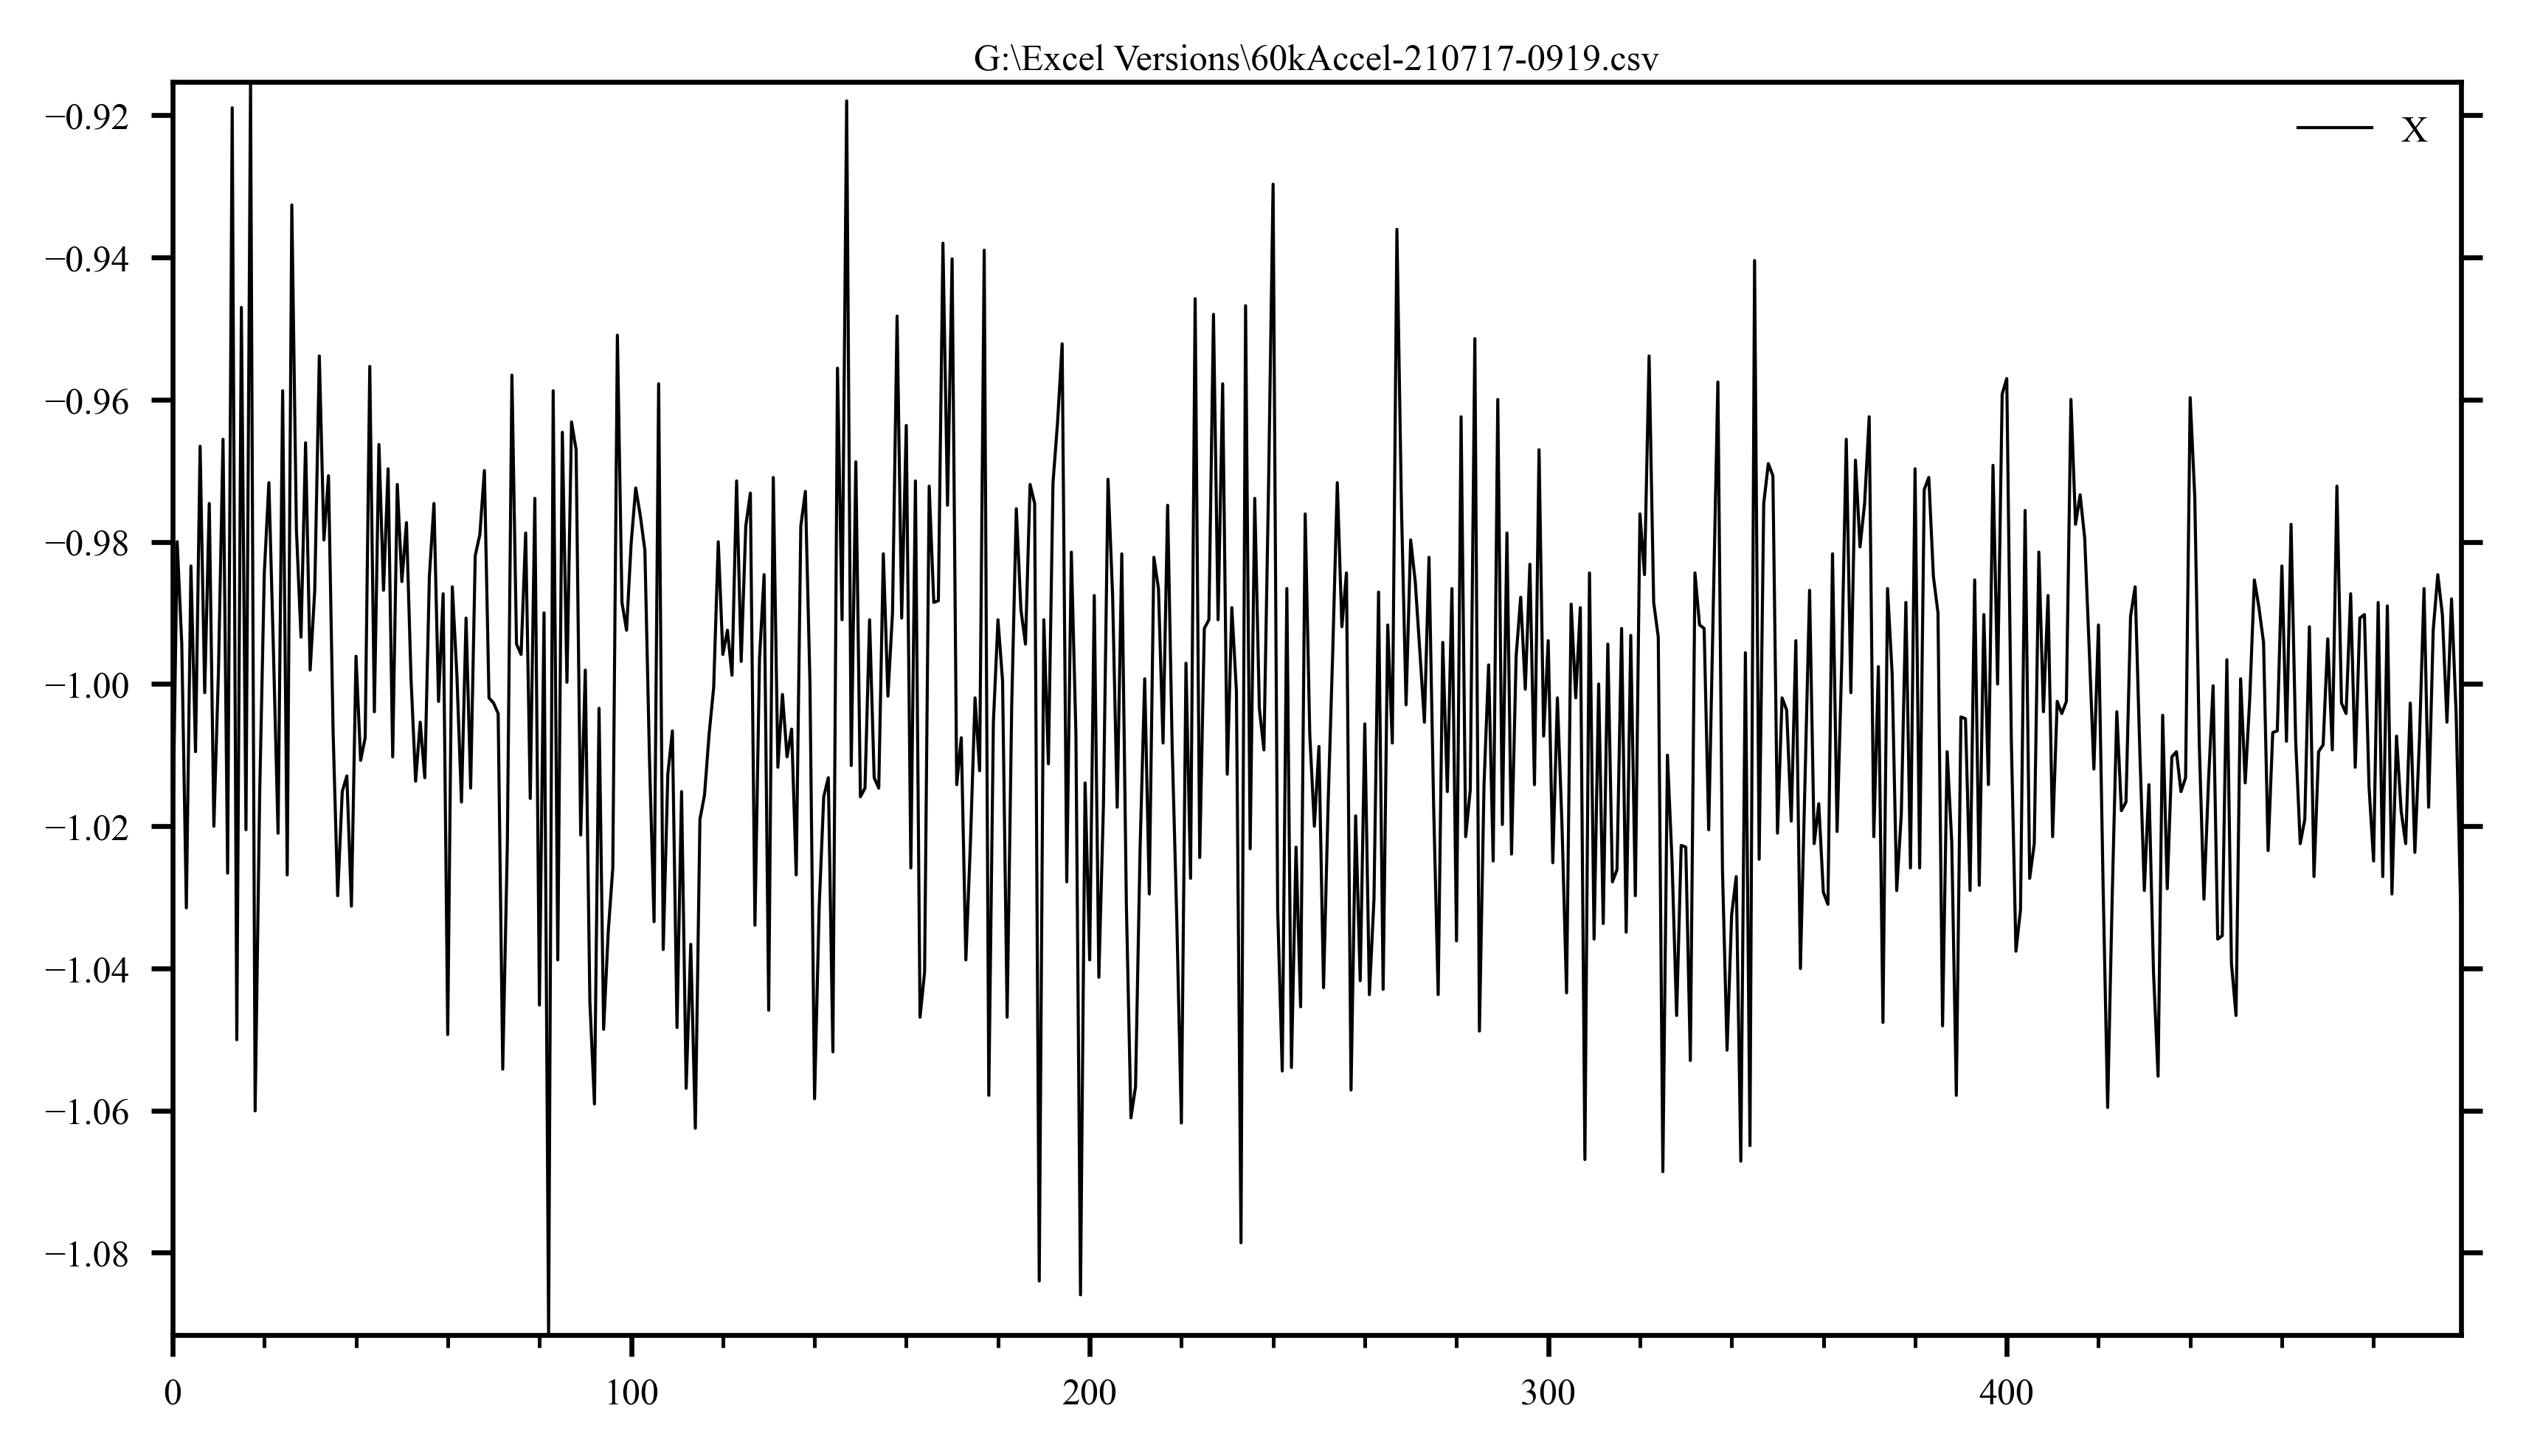

In [38]:
#Files = "G:\\Excel Versions\\60kAccel-210811-1837.csv"
Files = "G:\\Excel Versions\\60kAccel-210717-0919.csv"
DataSet = np.genfromtxt(open(Files,'r'), delimiter=',')

DataSet = DataSet[:,1:5]

coord = 3
start = 26750
end = 27250 #np.shape(DataSet)[0]

fig=plt.figure(figsize=(6.67,3.75))
#plt.plot(DataSet[:,0],DataSet[:,1], label = 'X')
#plt.plot(DataSet[:,0],DataSet[:,2], label = 'Y')
plt.plot(DataSet[start:end,coord], label = 'X')

title = Files

if Ledgends: plt.legend()
if Titles: plt.title(title)
if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
plt.show()


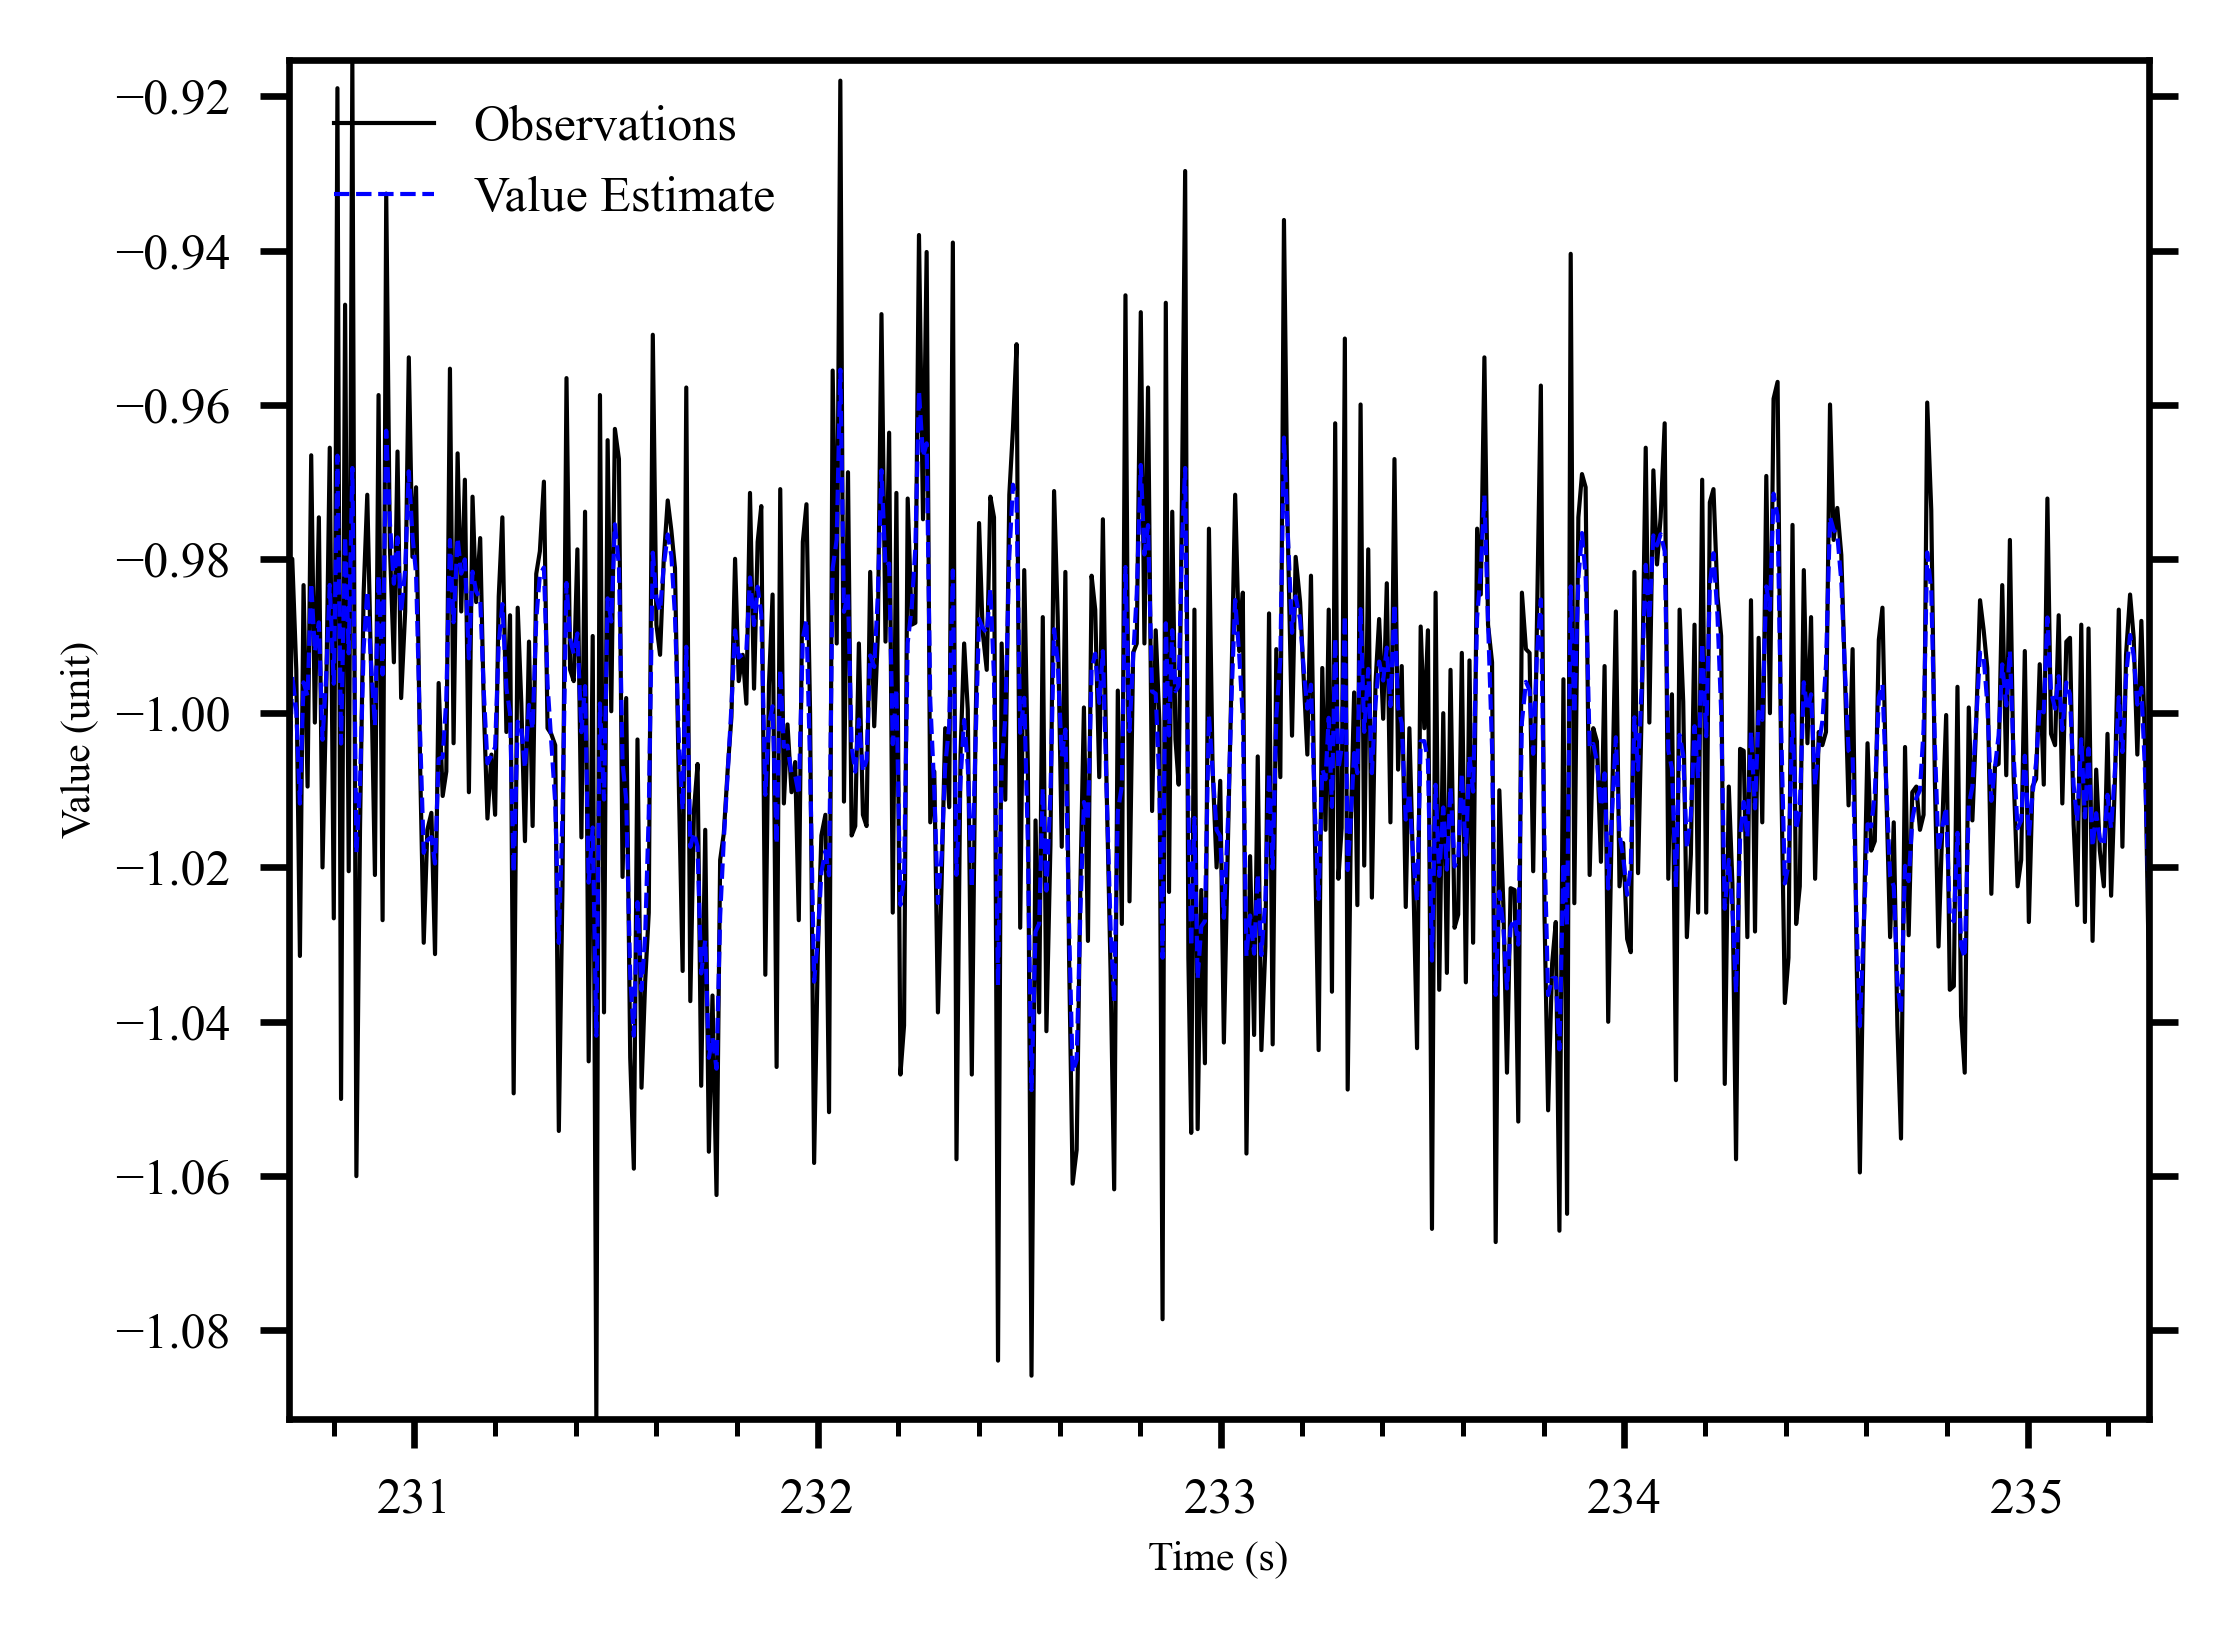

In [39]:
from pykalman import KalmanFilter
import copy

outlier_thresh = 0.95

# Treat y as position, and that y-dot is
# an unobserved state - the velocity,
# which is modelled as changing slowly (inertia)

# state vector [y,
#               y_dot]

# transition_matrix =  [[1, dt],
#                       [0, 1]]

observation_matrix = np.asarray([[1, 0]])

# observations:
t = np.transpose(DataSet[start:end,0])

# dt betweeen observations:
dt = [np.mean(np.diff(t))] + list(np.diff(t))
transition_matrices = np.asarray([[[1, each_dt],[0, 1]]
                                    for each_dt in dt])

# observations
y = (np.asarray(DataSet[start:end,3]))

y = np.ma.array(y)


#leave_1_out_cov = []

for i in range(len(y)):
    y_masked = np.ma.array(copy.deepcopy(y))
    y_masked[i] = np.ma.masked

    kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

    kf1 = kf1.em(y_masked)

    #leave_1_out_cov.append(kf1.observation_covariance[0,0])

# Find indexes that contributed excessively to observation covariance
#outliers = (leave_1_out_cov / np.mean(leave_1_out_cov)) < outlier_thresh

#for i in range(len(outliers)):
#    if outliers[i]:
#        y[i] = np.ma.masked


kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

kf1 = kf1.em(y)

(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(y)


plt.figure()
plt.plot(t, y, '-', label="Observations")
plt.plot(t, smoothed_state_means[:,0], 'b--', label="Value Estimate" )
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Value (unit)")

plt.show()